In [1]:
pip install networkx matplotlib python-louvain scipy seaborn

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached python_louvain-0.16-py3-none-any.whl
  Using cached scipy-1.15.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp312-cp312-win_amd64.whl.metadata (104 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached numpy-2.2.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached pillow-11.1.0-cp312-cp312-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import gzip
import community as community_louvain  # For Louvain community detection
import random
import pandas as pd
import seaborn as sns
import time 

In [60]:
def load_graph(edge_file):
    """
    Load an undirected graph from a (possibly gzipped) edge list file.
    Each line in the file contains two integers (node IDs) separated by whitespace.
    """
    G = nx.Graph()
    if edge_file.endswith(".gz"):
        f = gzip.open(edge_file, "rt", encoding="utf-8")
    else:
        f = open(edge_file, "r")
    
    with f as file:
        for line in file:
            node1, node2 = map(int, line.strip().split())
            G.add_edge(node1, node2)
    return G

# Example usage:
edge_filename = "facebook_combined.txt.gz"  # Change this to your edge file name
G = load_graph(edge_filename)
print(f"Graph Loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Graph Loaded: 4039 nodes, 88234 edges


In [61]:
def detect_communities_label_propagation(G):
    """
    Use NetworkX's asynchronous label propagation algorithm.
    Returns a list of sets, where each set is a community.
    """
    communities = list(nx.algorithms.community.asyn_lpa_communities(G, weight=None))
    return communities

communities = detect_communities_label_propagation(G)
print("Sample communities (first 5 nodes per community):")
for i, community in enumerate(communities):
    print(f"Community {i}: {list(community)[:5]}")

Sample communities (first 5 nodes per community):
Community 0: [0, 1, 3, 5, 6]
Community 1: [2, 262, 137, 140, 14]
Community 2: [195, 4, 328, 78, 273]
Community 3: [193, 259, 8, 201, 264]
Community 4: [266, 24, 299, 300, 302]
Community 5: [512, 513, 514, 515, 517]
Community 6: [159, 320, 36, 197, 135]
Community 7: [225, 321, 99, 68, 131]
Community 8: [49, 241, 255]
Community 9: [192, 52, 205]
Community 10: [307, 230, 70, 71]
Community 11: [97, 253, 182]
Community 12: [107, 526, 897, 899, 906]
Community 13: [112, 293, 174]
Community 14: [2048, 2051, 2052, 2053, 2054]
Community 15: [198, 454, 393, 364, 399]
Community 16: [256, 233]
Community 17: [282, 244]
Community 18: [2661, 2662, 2665, 2667, 2668]
Community 19: [1536, 1541, 1035, 1037, 1041]
Community 20: [1025, 1543, 1545, 1549, 1565]
Community 21: [644, 653, 654, 655, 657]
Community 22: [1036, 1550, 1044, 1060, 1573]
Community 23: [1281, 898, 1282, 1794, 1032]
Community 24: [1410, 900, 1033, 1803, 908]
Community 25: [901, 1798, 903,

In [62]:
def draw_communities(G, communities):
    # Assign a random color to each community.
    unique_communities = list(set(community for comm in communities for community in comm))
    # Here we build a mapping from each node to a color according to community membership
    color_map = {}
    for idx, comm in enumerate(communities):
        color = "#"+''.join(random.choice('0123456789ABCDEF') for _ in range(6))
        for node in comm:
            color_map[node] = color

    pos = nx.spring_layout(G, seed=42, k=0.15)
    node_colors = [color_map.get(node, "#cccccc") for node in G.nodes()]
    
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.7)
    plt.title("Communities Detected by Label Propagation")
    plt.show()

draw_communities(G, communities)


KeyboardInterrupt: 

In [ ]:
# Compute Local Clustering Coefficient for each node using NetworkX
local_clustering = nx.clustering(G)
# Example: Print first 10 nodes' values
print("Local Clustering Coefficient (first 10 nodes):")
for node, coeff in list(local_clustering.items())[:10]:
    print(f"Node {node}: {coeff:.2f}")


Local Clustering Coefficient (first 10 nodes):
Node 0: 0.04
Node 1: 0.42
Node 2: 0.89
Node 3: 0.63
Node 4: 0.87
Node 5: 0.33
Node 6: 0.93
Node 7: 0.43
Node 8: 0.68
Node 9: 0.40


In [7]:
def articulation_point_centrality(G):
    """
    Compute an articulation-point centrality measure.
    For each node v, if v is an articulation point, then
    A(v) = sum_{i=1}^{m_v} |S_i(v)| (the sum of the sizes of connected components obtained by removing v).
    Otherwise, A(v)=0.
    Returns a dictionary mapping node -> centrality value.
    """
    A = {node: 0 for node in G.nodes()}
    # Get the list of all articulation points
    art_points = list(nx.articulation_points(G))
    
    for v in art_points:
        # Make a copy of the graph and remove node v
        H = G.copy()
        H.remove_node(v)
        # Compute the sizes of all connected components in the resulting graph
        component_sizes = [len(c) for c in nx.connected_components(H)]
        # Sum the component sizes; this is a simple proxy for fragmentation impact.
        A[v] = sum(component_sizes)
    return A

articulation_centrality = articulation_point_centrality(G)
print("\nArticulation‑Point Centrality (for articulation points only):")
for node, val in articulation_centrality.items():
    if val > 0:
        print(f"Node {node}: {val}")



Articulation‑Point Centrality (for articulation points only):
Node 0: 4038
Node 107: 4038
Node 348: 4038
Node 414: 4038
Node 1684: 4038
Node 1912: 4038
Node 594: 4038
Node 3437: 4038
Node 3980: 4038
Node 686: 4038
Node 698: 4038


In [8]:
# Compute the k-core number for each node
core_numbers = nx.core_number(G)
print("\nK‑Core Numbers (first 10 nodes):")
for node, core_val in list(core_numbers.items())[:10]:
    print(f"Node {node}: {core_val}")



K‑Core Numbers (first 10 nodes):
Node 0: 21
Node 1: 13
Node 2: 9
Node 3: 13
Node 4: 9
Node 5: 10
Node 6: 5
Node 7: 12
Node 8: 5
Node 9: 21


In [64]:
import time
import random
import networkx as nx

def compute_mds_values_nx(G, rounds=10, nodes_subset=None):
    """
    Compute an MDS-derived score for each node in the graph (or induced subgraph).
    The MDS score for each node is computed as:
         m(v) = (final marked count) + (initial random offset)
    where the initial random offset was added to the node's degree.
    
    Parameters:
        G : NetworkX graph
        rounds : Number of rounds for weight and marking update.
        nodes_subset : Optional list of nodes to consider (induced subgraph).
    
    Returns:
        A dictionary mapping node -> MDS score.
    """
    # Work on a copy so the original graph is not modified.
    if nodes_subset is not None:
        H = G.subgraph(nodes_subset).copy()
    else:
        H = G.copy()
    
    # Record start (optional)
    start_time = time.perf_counter()

    # Step 1: Initialize each node with a random weight, markedcount, and marked flag.
    for node in H.nodes():
        # Each node gets an initial random offset.
        initial_offset = random.random()
        H.nodes[node]['weight'] = initial_offset  # initial weight from random offset
        H.nodes[node]['markedcount'] = 0
        H.nodes[node]['marked'] = False
        # Store the initial offset for later use.
        H.nodes[node]['initial_offset'] = initial_offset

    # Step 2: Increase each node's weight by its degree.
    for node in H.nodes():
        H.nodes[node]['weight'] += H.degree[node]

    # Step 3: Each node marks the neighbor with the maximum weight.
    for node in H.nodes():
        max_weight_neighbor = None
        max_weight = -1
        for neighbor in H.neighbors(node):
            if H.nodes[neighbor]['weight'] > max_weight:
                max_weight = H.nodes[neighbor]['weight']
                max_weight_neighbor = neighbor
        if max_weight_neighbor is not None:
            H.nodes[max_weight_neighbor]['marked'] = True
            H.nodes[max_weight_neighbor]['markedcount'] += 1

    # Step 4: Repeated rounds to update weights and markings.
    for _ in range(rounds):
        # Reinitialize each node's weight: new random component plus the number of times it was marked.
        for node in H.nodes():
            H.nodes[node]['weight'] = random.random() + H.nodes[node]['markedcount']
            H.nodes[node]['markedcount'] = 0  # reset count for the new round
            H.nodes[node]['marked'] = False

        # Each node marks its neighbor with the highest updated weight.
        for node in H.nodes():
            max_weight_neighbor = None
            max_weight = -1
            for neighbor in H.neighbors(node):
                if H.nodes[neighbor]['weight'] > max_weight:
                    max_weight = H.nodes[neighbor]['weight']
                    max_weight_neighbor = neighbor
            if max_weight_neighbor is not None:
                H.nodes[max_weight_neighbor]['marked'] = True
                H.nodes[max_weight_neighbor]['markedcount'] += 1

    # Step 5: For each node, compute its MDS score as: m(v) = (final marked count) + (initial offset)
    mds_values = {node: H.nodes[node]['markedcount'] + H.nodes[node]['initial_offset'] for node in H.nodes()}
    
    end_time = time.perf_counter()
    print("Time taken to compute MDS values:", (end_time - start_time) * 1000, "milliseconds")
    
    return mds_values

# Example usage on the entire graph:
mds_scores_full = compute_mds_values_nx(G, rounds=10)
print("Sample of MDS Scores on entire graph:", dict(list(mds_scores_full.items())))


Time taken to compute MDS values: 412.2864999808371 milliseconds
Sample of MDS Scores on entire graph: {0: 343.43894527224614, 1: 0.6056454141332014, 2: 0.8625075085851204, 3: 0.11244881331280965, 4: 0.4337500081637522, 5: 0.6907007472381324, 6: 0.5568896710428833, 7: 0.4280551300891411, 8: 0.16838415702621912, 9: 0.12913280417121276, 10: 0.4023138897780456, 11: 0.07410399176498572, 12: 0.35564453784404826, 13: 0.04799307970095679, 14: 0.7119108749973577, 15: 0.27505558601518876, 16: 0.05960515361906982, 17: 0.9795387362293153, 18: 0.009907161813615395, 19: 0.6781459913318661, 20: 0.3120999185817682, 21: 0.898820773488415, 22: 0.8875835350155583, 23: 0.41772149506239875, 24: 0.6648396601752424, 25: 0.6169209963689515, 26: 0.1141637802159865, 27: 0.9172798357901847, 28: 0.47734803319228314, 29: 0.8428081245976273, 30: 0.21656092643560165, 31: 0.37869847042607585, 32: 0.022044623358247306, 33: 0.4656955362954167, 34: 0.030632252035406538, 35: 0.8241436475910217, 36: 0.1514380875477136, 3

In [65]:
# Compute the MDS-derived scores for each community
community_mds_scores = {}

# Iterate over each community (here communities is a list of sets)
for idx, community in enumerate(communities):
    community_nodes = list(community)
    
    # Check that the community is not empty
    if len(community_nodes) == 0:
        continue
    
    # Compute the MDS scores on the subgraph induced by the community nodes.
    mds_scores = compute_mds_values_nx(G, rounds=10, nodes_subset=community_nodes)
    
    # Store the computed MDS scores in a dictionary keyed by community index
    community_mds_scores[idx] = mds_scores
    
    # Print the community nodes and corresponding MDS scores.
    print(f"Community {idx} (nodes: {community_nodes})")
    print("MDS Scores:", mds_scores)
    print("-" * 50)


Time taken to compute MDS values: 9.290600079111755 milliseconds
Community 0 (nodes: [0, 1, 3, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 18, 21, 22, 23, 25, 26, 27, 29, 30, 31, 33, 35, 37, 38, 39, 40, 42, 43, 45, 47, 48, 50, 51, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 72, 73, 74, 75, 76, 77, 79, 81, 82, 83, 84, 85, 87, 88, 89, 90, 95, 96, 98, 100, 103, 104, 105, 106, 109, 113, 114, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 132, 133, 134, 138, 141, 142, 145, 146, 147, 148, 150, 153, 154, 155, 156, 157, 158, 160, 161, 163, 164, 165, 166, 168, 169, 170, 171, 172, 176, 178, 179, 183, 185, 186, 188, 189, 190, 191, 199, 200, 202, 203, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 3290, 219, 221, 222, 223, 224, 228, 229, 231, 232, 234, 235, 236, 237, 238, 239, 240, 246, 247, 248, 250, 252, 257, 258, 260, 261, 265, 267, 268, 269, 270, 271, 272, 274, 276, 277, 2838, 279, 280, 283, 285, 286, 287, 288, 290, 291, 292, 294, 295, 297, 298, 301, 303, 304, 305

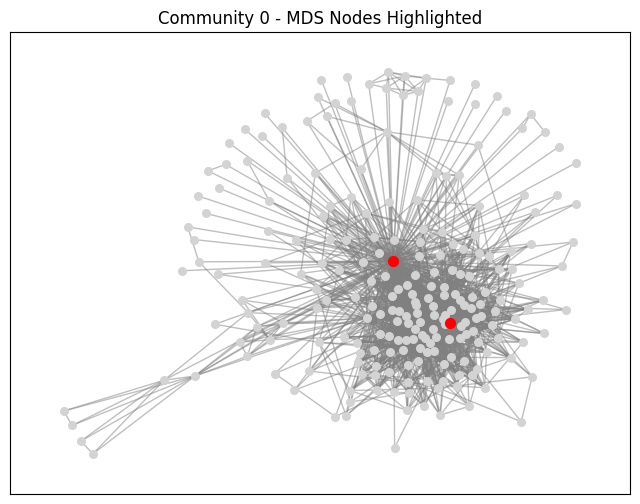

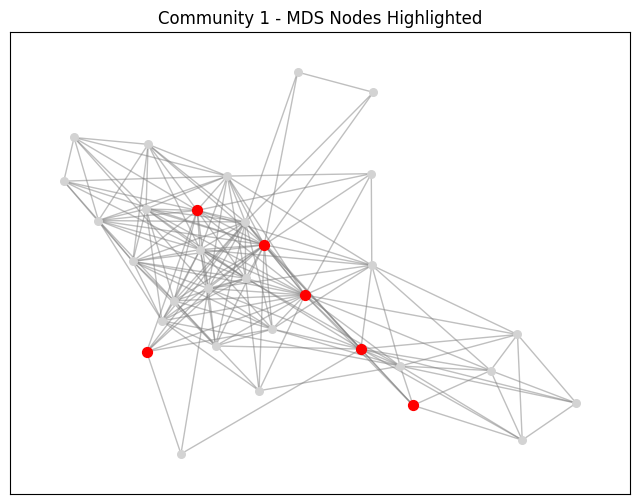

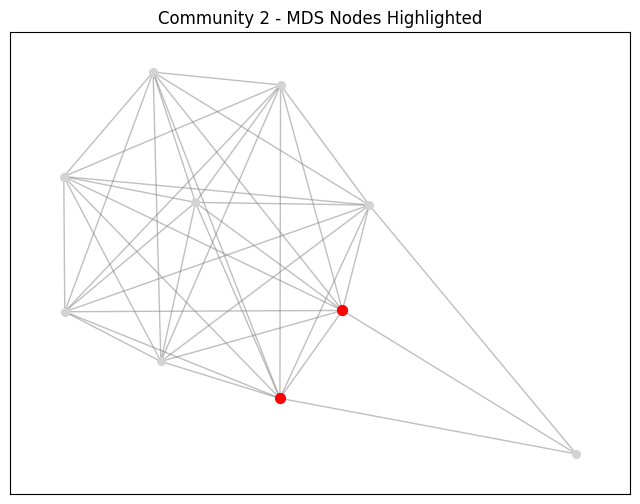


KeyboardInterrupt



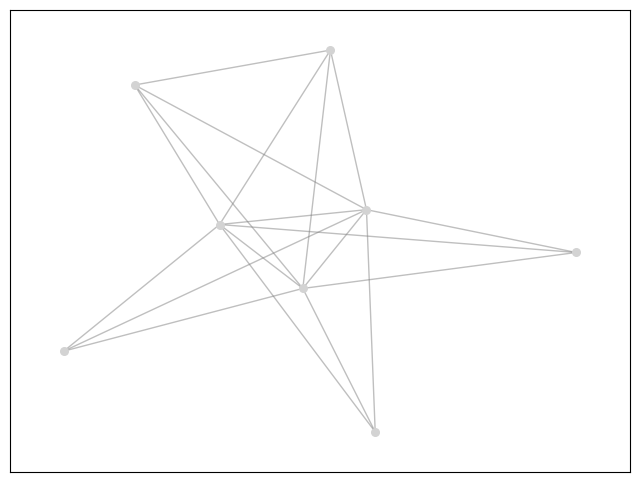

In [67]:
for idx, community in enumerate(communities):
    community_nodes = list(community)
    subgraph = G.subgraph(community_nodes)
    mds_nodes = community_mds[idx]
    
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(subgraph, seed=42)
    
    # Draw all nodes in light gray
    nx.draw_networkx_nodes(subgraph, pos, node_color='lightgray', node_size=30)
    # Draw edges in gray
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.5)
    # Highlight the MDS nodes in red
    nx.draw_networkx_nodes(subgraph, pos, nodelist=mds_nodes, node_color='red', node_size=50)
    
    plt.title(f"Community {idx} - MDS Nodes Highlighted")
    plt.show()


In [72]:
import math

# Define a small constant for flooring
delta = 1e-3

# 1. Normalize Local Clustering: For each node, use max(C(v), delta).
norm_clustering = {node: max(coeff, delta) for node, coeff in local_clustering.items()}

# 2. Normalize Articulation-Point Centrality:
# First, find the maximum A(v) among nodes that are articulation points.
max_A = max(articulation_centrality.values()) if any(val > 0 for val in articulation_centrality.values()) else delta
norm_articulation = {}
for node in G.nodes():
    A_val = articulation_centrality.get(node, 0)
    # If not an articulation point, set value to delta.
    norm_articulation[node] = (A_val / max_A) if A_val > 0 else delta

# 3. Normalize K-Core Numbers:
max_core = max(core_numbers.values()) if core_numbers else 1
norm_kcore = {node: (core_numbers[node] / max_core) for node in G.nodes()}

# 4. Normalize MDS-derived scores:
max_mds = max(mds_scores_full.values()) if mds_scores_full else 1
norm_mds = {node: (mds_scores_full[node] / max_mds) for node in G.nodes()}

# 5. Compute LACM-Score for each node using the geometric mean of the four normalized scores.
lacm_scores = {}
for node in G.nodes():
    product = norm_clustering[node] * norm_articulation[node] * norm_kcore[node] * norm_mds[node]
    lacm_scores[node] = math.pow(product, 1/4)

# Display results for the first 10 nodes
print("LACM-Scores (first 10 nodes):")
for node, score in list(lacm_scores.items())[:10]:
    print(f"Node {node}: {score:.3f}")

# Optional: Create a DataFrame to view all computed values side-by-side.
import pandas as pd

data = []
for node in G.nodes():
    data.append({
        "Node": node,
        "LocalClustering": local_clustering.get(node, 0),
        "NormLC": norm_clustering[node],
        "ArticulationCentrality": articulation_centrality.get(node, 0),
        "NormArt": norm_articulation[node],
        "KCore": core_numbers.get(node, 0),
        "NormKCore": norm_kcore[node],
        "MDS": mds_scores_full.get(node, 0),
        "NormMDS": norm_mds[node],
        "LACM": lacm_scores[node]
    })

df_lacm = pd.DataFrame(data)
print("\nLACM-Scores DataFrame (first 10 rows):")
print(df_lacm.head(10))


LACM-Scores (first 10 nodes):
Node 0: 0.224
Node 1: 0.013
Node 2: 0.015
Node 3: 0.009
Node 4: 0.013
Node 5: 0.012
Node 6: 0.012
Node 7: 0.012
Node 8: 0.008
Node 9: 0.010

LACM-Scores DataFrame (first 10 rows):
   Node  LocalClustering    NormLC  ArticulationCentrality  NormArt  KCore  \
0     0         0.041962  0.041962                    4038    1.000     21   
1     1         0.419118  0.419118                       0    0.001     13   
2     2         0.888889  0.888889                       0    0.001      9   
3     3         0.632353  0.632353                       0    0.001     13   
4     4         0.866667  0.866667                       0    0.001      9   
5     5         0.333333  0.333333                       0    0.001     10   
6     6         0.933333  0.933333                       0    0.001      5   
7     7         0.431579  0.431579                       0    0.001     12   
8     8         0.678571  0.678571                       0    0.001      5   
9     9   

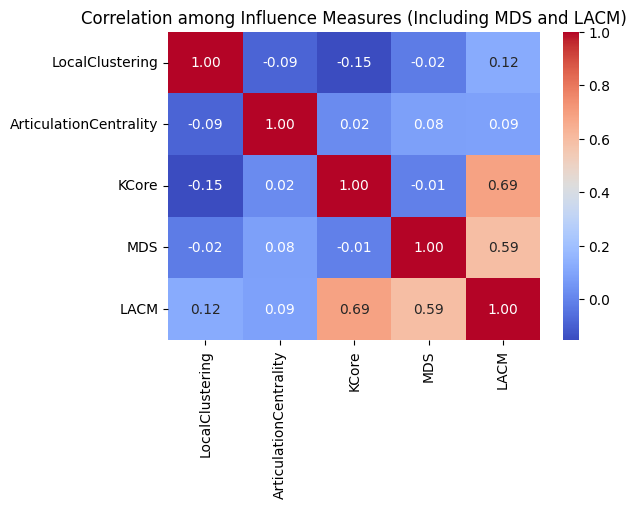

In [74]:
# Compute and visualize the correlation matrix (Spearman's rank correlation)
# Ensure that the DataFrame 'df' includes columns "LocalClustering", "ArticulationCentrality",
# "KCore", "MDS", and "LACM" corresponding to the respective measures.
corr_matrix = df_lacm[["LocalClustering", "ArticulationCentrality", "KCore", "MDS", "LACM"]].corr(method="spearman")

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation among Influence Measures (Including MDS and LACM)")
plt.show()
